<h1 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color:rgb(52, 152, 219); text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)">Préparation des données</h1>
<br/>
<br/>
  

<h1 style="font-family: 'Georgia', serif; text-align: center; font-size: 25px; color: #3498db">1- <u>reduction du nombre de variable de base_edu </u></h1>
    

In [ ]:
!pip install fastparquet
!pip install rpy2
!pip install pandas
!pip install matplotlib

In [16]:
#importation des packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
#chemin de la Base de données; 
#commentez l'url et vous remplacez par votre chemin sans supprimer!!!!!

url="/home/onyxia/work/Projet_Statistique/data/base_Edu.parquet"
base_Edu=pd.read_parquet(url)
base_Edu.head()

,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,first_theory_activity_date,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,3838161406066513919,41,0,2017-12-17 15:00:23.000000,265,0,3,0,3,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
1,5829430568065349352,0,0,2022-07-07 12:02:53.000000,27,0,0,0,11,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
2,7677180318050051984,787,788,2022-05-10 01:35:49.000000,295,0,0,0,73,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
3,-5150597998144597550,615,616,2024-04-18 04:56:03.262330,138,0,0,0,75,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
4,969323468959211246,169,170,2019-03-19 12:32:56.000000,554,0,0,0,41,120,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0


In [3]:
print(base_Edu.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 477 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(72), boolean(254), datetime64[us](1), float64(150)
memory usage: 450.9 MB
None


La base de données compte donc 477 variables dont 72 de type Int, 254 de type boolean, 1 de type datetime et 150 de type float soit au total 254 variables qualitatives (**boolean**) et 221 variables quantitatives(**float + int** en excluant les identifiants) sans oublier la variable de type **datetime**.

Nous commencons par épurer la base données avant de passer à la réduction de dimension. On s'intéressera aux valeurs manquantes. 

In [4]:
missing_value=(base_Edu.isnull().sum()/len(base_Edu))
missing_value[missing_value>0]
missing_value[missing_value>0].describe()

count    404.000000
mean       0.743390
std        0.279055
min        0.047720
25%        0.666710
50%        0.842345
75%        0.918625
max        1.000000
dtype: float64

La base de données comporte donc 404 variables avec valeurs manquantes sur le total des 476 variables de la base ce qui n'est pas du tout négligeable. Voyons combien de valeurs manquantes at-on par type de variables. 

In [5]:
print(base_Edu.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(base_Edu.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(base_Edu.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(base_Edu.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

48  variables de type int ont des valeurs manquantes
103  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


La seule variable de type datetime n'a donc pas de valeurs manquantes.  Analysons de plus près les proportions de valeurs manquantes des autres types

In [6]:
miss_bool=base_Edu.select_dtypes("boolean").isnull().sum()/len(base_Edu)
miss_bool[miss_bool>0].describe()

count    253.000000
mean       0.903116
std        0.072136
min        0.695085
25%        0.837765
50%        0.883305
75%        1.000000
max        1.000000
dtype: float64

Les variables de type boolean comporte pratiquement tous assez de valeurs manquantes avec un minimum de 69% et un maximum de 100% du total des observations

Les valeurs manquantes de la base ne sont pas complètement aléatoires. Elles ne sont pas pour la plupart le fruit d'une mauvaise collecte de données. La présence de valeurs manquantes dans cette base est due à diverses raisons notamment le fait que plusieurs individus de la base n'ont pas encore passé d'examen pour le permis. Plusieurs questions(variables) n'ont de sens que dans le cas où le premier examen est passé. Il y a donc une part d'information apporté par ces valeurs manquantes que nous devons inclure dans nos analyses. Pour les variables booléenne, nous pouvons régler ce prblème c'est à dire prendre en compte l'information apportée par ces valeurs manquantes en transformant les variables booléennes en variable catégorielles en considérant les valeurs manquantes comme une catégorie(True=1,False=0 et NA=2).

In [7]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=base_Edu.select_dtypes("boolean").columns
for col in colboo:
    base_Edu[col] = encode_column_with_na(base_Edu[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories


Passons maintenant aux variables quantitatives (int+float)

In [8]:
miss_quant=base_Edu.select_dtypes(include=["int","float"]).isnull().sum()/len(base_Edu)
miss_quant[miss_quant>0].describe()

count    151.000000
mean       0.475770
std        0.292138
min        0.047720
25%        0.184915
50%        0.483995
75%        0.736010
max        0.941710
dtype: float64

Pour les variables quantitatives, la distribution des valeurs manquantes est plus étendue. On enregistre 151 variables quantitatives avec valeurs manquantes. On a un minimum de 4% et un maximum de 94% de valeurs manquantes par rapport au total d'observation(nous rappelons 200000 obervations). La nature des variables et la distribution des valeurs manquantes dans ce cas ne facilite pas la capture de l'information apportée par la présence de ces valeurs manquantes. On pourrait opter pour une imputation par KNN ou par imputation itérative (MICE) mais cela risque de modifier et significativement les corrélations existant déjà entre les variables introduisant ainsi un important biais et au vue de la taille de l'echantillon, cela demanderait un temps d'excution énorme. On choisit ici donc de procéder à une imputation par la médiane après suppression des variables avant un taux élevé de valeurs manquantes pour minimiser le biais. Cela permettra de ne pas trop distordre les distributions existentes.

In [9]:
miss_quant[miss_quant<=0.20].describe()

count    118.000000
mean       0.054362
std        0.074368
min        0.000000
25%        0.000000
50%        0.000000
75%        0.106310
max        0.194530
dtype: float64

Nous choisissons le seuil de 20% de valeurs manquantes. Ce seuil nous parait raisonnable puisqu'il est relativement faible et n'entraine pas la suppression d'un grand nombre de variables quantitatives (118 sont conservées sur un total de 151)

In [10]:
#suppression des variables avec plus de 20% de valeurs manquantes
base_Edu=base_Edu.drop(columns=miss_quant[miss_quant>0.20].index)
#Imputation par la médiane
col=base_Edu.select_dtypes(exclude='category').columns
base_Edu[col] = base_Edu[col].fillna(base_Edu[col].median())

In [11]:
base_Edu.isnull().any().sum()

np.int64(0)

In [12]:
df1 = base_Edu.select_dtypes(exclude=['datetime64'])  # Colonnes non datetime64
df2 = base_Edu.select_dtypes(include=['datetime64']) #colonnes datetime
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 372 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(47), category(254), float64(71)
memory usage: 237.5 MB


In [13]:
#sauvegarde des données sans var date
df1.to_parquet('data_Edu.parquet', index=False)

Plus aucune valeur manquante. La base de données enfin prête, on peut passer aux opérations de réduction de dimension

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;color:rgb(47, 99, 220);font-size: 30px">
<u>
Réduction de dimension</u>
</p>
<br/>

Etant donnée la dimension de la base de données( beaucoup de variables), ce sera très complexe voir impossible de faire des analyses ou entrainer un modèle directement sur cette base. Il est donc important voir optimale de faire au préalable une réduction de dimension. Pour ce faire, nous allons utiliser différentes approches de réduction de dimension, faire des comparaisons puis retenir la meilleure approche dans ce cas. Il s'agira principalement de faire une **analyse enn composante principale (ACP)** , une **FAMD** et utiliser **un autoencodeur**.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
1- Analyse en composantes principales (ACP) </u>
</p>
<br/>

Pour effectuer l'ACP il faut restreindre la base aux variables quantitatives.

In [14]:
data=base_Edu.select_dtypes(include=["int","float"])
data=data.drop(["unique_learner_id"], axis=1)

Par la suite, nous allons standardiser les variables afin de faire qu'elles aient toutes la même échelle car l'ACP dépend fortement de l'échelle des variables.

In [17]:
scaler =StandardScaler()
X_scaled =scaler.fit_transform(data)

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
 a)- Choix du nombre de composantes principales
</p>
<br/>

#### **Règle du coude**

Il s'agit ici de construire la courbe de décroissance des valeurs propres et de détecter des "coudes" (ou "cassures") signalant un changement de structure.

Text(0.5, 0, 'Principal components')

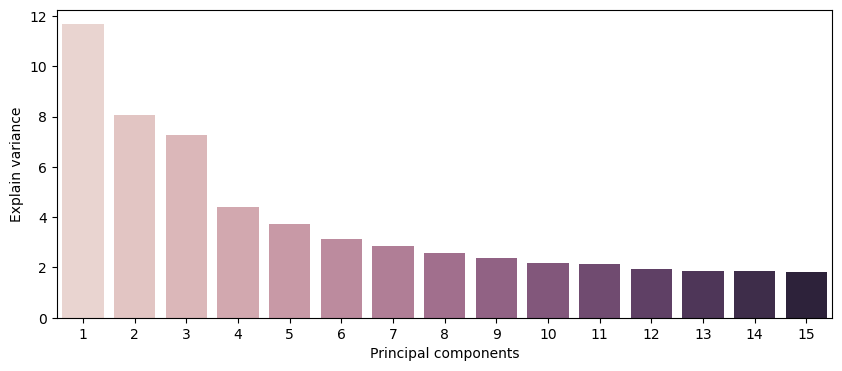

In [18]:
plt.figure(figsize=(10, 4))
pca=PCA(n_components=15)
pca.fit(X_scaled)
sns.barplot(x= np.arange(1,16) , y=pca.explained_variance_ratio_*100, hue=np.arange(1,16), legend=False)
plt.ylabel("Explain variance")
plt.xlabel("Principal components")

On observe de ce graphique qu'il y a deux coudes possibles, l'un à la deuxième composante et l'autre à la sixième composante. La première composante principale explique 11,66% de la variance totale, la deuxième en explique 8,05%, la troisième 7,27%, et à partir de la sixième composante principale, le pourcentage de variable expliquée devient inférieur à 3%. Les facteurs restants ont donc un apport d'information négligeable.

A ce graphique, on ajoute le graphique qui décrit l'évolution de la variance expliquée par les axes.

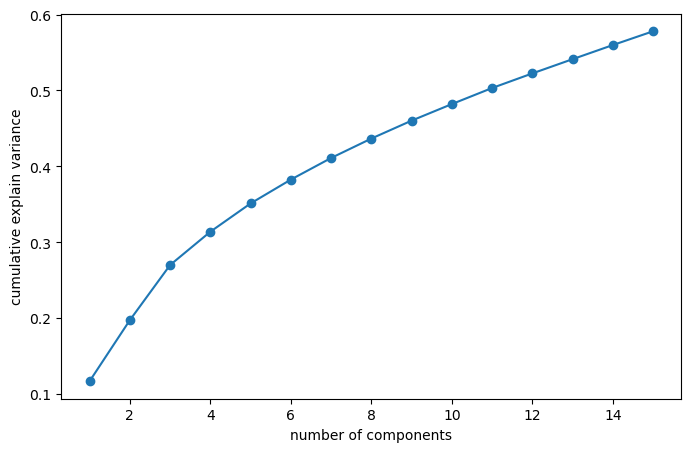

In [19]:
explained_variances=[]
for n in range(1,16):
    pca =PCA(n_components=n)
    pca.fit(X_scaled)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8,5))
plt.plot(range(1,16), explained_variances, marker='o')
plt.xlabel("number of components")
plt.ylabel("cumulative explain variance")
plt.show()

Ce graphique montre que les 6 premières composantes principales expliquent environ 39% de l'information. Considerer deux composantes principales n'est pas une bonne idée car on perdrais le gain d'information substanciel qu'apporte les 4 composantes principales suivantes.

#### **Test des « bâtons brisés »**

Ce test est du à Frontier (1976) et Legendre-Legendre (1983). Il repose sur l’idée que si l’inertie totale était dispatchée aléatoirement sur les axes, la distribution des valeurs propres suivrait la loi des 
« bâtons brisés » (broken-stick). La valeur critique pour le choix des composantes principales s'écrit comme suit:
$$ b_{k} = \sum_{i=k}^{p} \frac 1 {i}$$

où p représente le nombre de variables.

In [20]:
baton_coef=[]
for i in np.arange(1,16):
    n=0
    for j in range(i,117):
        n=n+(1/j)
    baton_coef.append(n)

In [21]:
data1=pd.DataFrame(data=pca.explained_variance_, columns=["eigen_values"])
data1["b_k"]=baton_coef
data1.index=["PC{}".format(i) for i in np.arange(1,16)]
data1

,eigen_values,b_k
PC1,11.433010,5.335110
PC2,7.889850,4.335110
PC3,7.125282,3.835110
PC4,4.303661,3.501777
PC5,3.656646,3.251777
PC6,3.079446,3.051777
PC7,2.793093,2.885110
PC8,2.510063,2.742253
PC9,2.316068,2.617253
PC10,2.140029,2.506142


Avec ce test on retient bien 6 composantes principales, car jusqu'a la sixième composante principale, la valeur propre de chaque composante est bien supérieur au seuil calculé.

Nous retiendrons donc 6 composantes principales dans la suite.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
b)- Entrainement du modèle
</p>
<br/>

In [22]:
# training the model with 6 principal components
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)
print("Explain variance for each component :",pca.explained_variance_ratio_)
print("cumulated variance :",pca.explained_variance_ratio_.sum())

Explain variance for each component : [0.11666279 0.08050827 0.0727066  0.04391469 0.03731253 0.03142276]
cumulated variance : 0.3825276432979798


In [23]:
# coefficients of the principal components 
print("Composantes principales (coefficients) :")
table_coef=pd.DataFrame(pca.components_, columns=data.select_dtypes(exclude='category').columns)
table_coef.index=["PC{}".format(i+1) for i in np.arange(0,6)]
table_coef

Composantes principales (coefficients) :


,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,percentage_activities_2_3_4h_week,percentage_activities_5_6_7h_week,percentage_activities_23_0_1h_week,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
PC1,0.066023,0.075380,-0.004304,-2.775558e-17,0.117614,0.108084,0.151237,-0.005015,0.010848,0.006412,...,0.124556,0.124960,0.125143,0.096558,0.017135,-0.004208,0.089261,0.075793,0.014699,-0.085941
PC2,-0.008065,-0.011528,0.001866,-5.551115e-17,0.064442,0.019720,0.024426,0.005472,-0.002838,0.010552,...,0.309994,0.305893,0.300151,0.033900,0.009574,0.012058,0.210167,-0.048970,0.004089,0.027051
PC3,0.011085,0.024568,-0.029454,2.775558e-17,0.054100,-0.053615,0.048469,-0.009290,0.005750,-0.014141,...,-0.038576,-0.037714,-0.036979,-0.021818,-0.007792,0.092365,-0.025102,-0.109213,-0.007508,0.111340
PC4,0.012075,0.023671,0.102459,5.551115e-17,0.172124,0.000509,0.288040,0.011691,0.003262,0.014421,...,-0.053972,-0.051355,-0.047792,0.081472,0.001146,0.133412,-0.050539,-0.034476,-0.001302,0.039099
PC5,0.096317,0.049701,0.418382,5.551115e-17,0.002792,-0.017294,0.017500,0.011576,0.012686,0.004933,...,-0.000584,-0.000301,0.000041,0.023312,0.006522,0.019306,-0.008350,0.023635,0.005007,-0.022552
PC6,0.182581,0.171615,-0.019994,-5.551115e-17,-0.034044,-0.000467,0.027862,0.024514,0.005893,0.064625,...,-0.009708,-0.008219,-0.006514,0.060201,0.015828,-0.188849,0.006282,0.300840,0.016464,-0.301232


In [24]:
# contributions of the principal components
loadings=pca.components_.T
eigenvalues=pca.explained_variance_
contributions=(loadings**2)*eigenvalues
contrib_percent=contributions/(eigenvalues.sum())*100
contrib_df=pd.DataFrame(contrib_percent, columns=["PC{}".format(i+1) for i in np.arange(0,6)])
contrib_df.index=data.columns
contrib_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
days_between_signup_and_first_activity,1.329430e-01,1.368918e-03,2.335643e-03,1.673759e-03,9.048918e-02,2.738366e-01
days_between_order_and_first_activity,1.732939e-01,2.796750e-03,1.147270e-02,6.432332e-03,2.409466e-02,2.419320e-01
days_between_first_and_last_activities,5.648254e-04,7.329077e-05,1.648967e-02,1.205164e-01,1.707412e+00,3.283896e-03
chapter_before_success_count,2.349471e-32,6.485421e-32,1.464237e-32,3.537590e-32,3.005746e-32,2.531291e-32
serie_before_success_count,4.218814e-01,8.740119e-02,5.562899e-02,3.401181e-01,7.601261e-05,9.520390e-03


<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
c)- Interprétaion des axes principaux
</p>
<br/>

Seront considérées comme variables les plus contributrices à la formation d'un axe principale, les variables dont la contribution est supérieur à la contribution moyenne, c'est-à-dire: $$ 100/117 \approx 0.855 $$  

In [25]:
contrib1=pd.DataFrame(data=contrib_df["PC1"].sort_values(ascending=False)[:16].values, columns=["contribution"]) 
contrib1.index=contrib_df["PC1"].sort_values(ascending=False)[:16].index
contrib1["coefficient"]=table_coef[contrib1.index].iloc[0]
contrib1

,contribution,coefficient
notions_diverses_number_of_activities,1.344225,0.209943
mecanique_equipements_number_of_activities,1.304631,0.206828
prendre_quitter_vehicule_number_of_activities,1.288815,0.205570
autres_usagers_number_of_activities,1.288610,0.205554
route_number_of_activities,1.269300,0.204008
securite_number_of_activities,1.264361,0.203611
premiers_secours_number_of_activities,1.257594,0.203065
environnement_number_of_activities,1.214696,0.199572
conducteur_number_of_activities,1.154733,0.194584
score_pct__quantile__q_0_4,0.999702,0.181051


Les variables qui contribuent le plus à la construction de la première composante principale sont des variables qui renseigne sur le nombre d'activité effectuer par thématique pour le permis de conduire (*notions_diverses_number_of_activities*, *mecanique_equipements_number_of_activities*,*securite_number_of_activities*, *route_number_of_activities*, *prendre_quitter_vehicule_number_of_activities*, *autres_usagers_number_of_activities*,etc.) et les statistiques qui résultent des scores en pourcentage obtenus aux différents examens notamment les quantiles d'ordre 1, 2, 3 et 4 (*score_pct__quantile__q_0_1*, *score_pct__quantile__q_0_2*, *score_pct__quantile__q_0_3*, *score_pct__quantile__q_0_4*), et .... Cet axe résume le signal et/ou la corrélation qui existe entre le nombre d'activités effectués par thématique et la distribution du score au différents examens. On pourrait donc dire qu'il traduit l'**efficacité** des étudiants.

De plus, en analysant les coefficients de ces variables, ont constate qu'elles sont toutes positifs. Ainsi, un individu ayant un coefficient élevé sur cet axe, fait beaucoup d'activité sur les différentes thématiques d'apprentissage et a des scores élevés aux différents examens, ce qui signifie qu'il comprend bien ce qu'il fait.

In [26]:
contrib2=pd.DataFrame(data=contrib_df["PC2"].sort_values(ascending=False)[:9].values, columns=["contribution"]) 
contrib2.index=contrib_df["PC2"].sort_values(ascending=False)[:9].index
contrib2["coefficient"]=table_coef[contrib2.index].iloc[1]
contrib2

,contribution,coefficient
nb_weeks_weekly_study_objective_reached_90pct,2.063731,0.313139
nb_weeks_weekly_study_objective_reached_85pct,2.052990,0.312323
nb_weeks_weekly_study_objective_reached_95pct,2.052586,0.312293
nb_weeks_weekly_study_objective_reached_99pct,2.034116,0.310884
nb_weeks_weekly_study_objective_reached,2.027262,0.310360
nb_weeks_weekly_study_objective_reached_80pct,2.022480,0.309994
nb_weeks_weekly_study_objective_reached_75pct,1.969327,0.305893
nb_weeks_weekly_study_objective_reached_70pct,1.896084,0.300151
pct_study_objective_reached,0.929620,0.210167


Les variables qui contribuent fortement à la deuxième composante principale sont d'une part les variables qui renseignent sur le nombre de week-end où les objectifs d'étude hebdomadaire ont atteint un pourcentage donnée (90%,85%,95%,99%,75%,etc) et d'autre part les variables qui donnent le pourcentage d'objectifs d'études atteint le week-end (*nb_weeks_weekly_study_objective_reached*) et en dehors (*pct_study_objective_reached*). On pourrait dire que cet axe capture principalement l'information sur **l'intensité du travail personnel des étudiants**. 

De plus, le coefficient de toutes les variables qui contribuent le plus à la formation de l'axe 2 sont positifs. Donc, les individus qui ont un coefficient élevé et positif sur cet axe (se trouvant à une extrémité de l'axe) sont beaucoup investit personnellement dans la formation.

In [27]:
contrib3=pd.DataFrame(data=contrib_df["PC3"].sort_values(ascending=False)[:8].values, columns=["contribution"]) #pas terminé
contrib3.index=contrib_df["PC3"].sort_values(ascending=False)[:8].index
contrib3["coefficient"]=table_coef[contrib3.index].iloc[2]
contrib3 #pas terminé

,contribution,coefficient
score_pct__quantile__q_0_2,1.265231,0.258006
score_pct__quantile__q_0_3,1.249015,0.256347
score_pct__quantile__q_0_1,1.215016,0.252834
score_pct__quantile__q_0_4,1.205133,0.251804
score_pct__linear_trend__attr_intercept,1.051538,0.235211
score_pct__c3__lag_1,1.035590,0.233420
score_pct__c3__lag_2,0.985957,0.227758
score_pct__c3__lag_3,0.931526,0.221382


Les variables qui contribuent fortement à la 3e composante principale sont les variables qui caractérisent la distribution du score en pourcentage (notamment les quantiles et ...) aux différents examens renseignées pour chaque étudiant. On peut dire que cet axe capture l'information sur **la progression des étudiants en terme de résultats**. 

De plus, le fait que toutes ces variables ont un coefficient positif sur l'axe signifient qu'elles varient dans le même sens que l'axe. Donc un étudiant ayant un coefficient très faible (négatif) sur cet axe, obtient de mauvais résultats aux différents examens, ce qui traduit le fait qu'ils n'assimilent pas bien les connaissances.

In [28]:
contrib4=pd.DataFrame(data=contrib_df["PC4"].sort_values(ascending=False)[:6].values, columns=["contribution"]) #pas terminé
contrib4.index=contrib_df["PC4"].sort_values(ascending=False)[:6].index
contrib4["coefficient"]=table_coef[contrib4.index].iloc[3]
contrib4

,contribution,coefficient
score_pct__standard_deviation,1.236983,0.328253
score_pct__variation_coefficient,1.102432,0.309886
score_pct__minimum,1.070068,-0.305304
nb_failed_series,1.008303,0.296362
theory_activities_total,0.952472,0.288040
session_count,0.903266,0.280501


La mesure de la dispersion du score (*score_pct_standard_deviation*)  et la variation relative du score en pourcentage autour de la moyenne (*score_pct__variation_coefficient*)  contribuent majoritairement à la formation de la 4e composante principale. Aussi, le nombre d'examens échoués (*nb_failed_series*), le total d'activités théorique (*theory_activities_total*), le minimum du score en pourcentage (*score_pct_minimum*) , le nombre de session effectué (*session_count*), contribuent également fortement à la formation de cet axe. Cette composante semble donc être fortement influencé par des variables liées à **la performance académique, à la régularité aux examens**. 

De l'analyse des coefficients de ces variables, on observe que les variables qui donne le minimum du score en pourcentage et la dernière localisation du minimum du score ont des coefficients négatifs. On pourrait donc dire que les individus ayant un score élevé sur cette composante sont succeptibles d'avoir des performances très irrégulières (caractérisées par une dispersion élevée des scores), rencontrent régulièrement des échecs et mettent du temps à assimiler les compétences (nombre de series échoué élevé), ce qui impliquent qu'ils doivent faire plus d'activités, d'examen et de session (**theory_activities_total**,**session_count**).

In [29]:
contrib5=pd.DataFrame(data=contrib_df["PC5"].sort_values(ascending=False)[:4].values, columns=["contribution"]) #pas terminé
contrib5.index=contrib_df["PC5"].sort_values(ascending=False)[:4].index
contrib5["coefficient"]=table_coef[contrib5.index].iloc[4]
contrib5

,contribution,coefficient
minutes_between_sessions_max,1.856332,0.436246
days_between_first_and_last_activities,1.707412,0.418382
minutes_between_sessions_avg,1.444263,0.384793
minutes_between_sessions_std,1.346260,0.371508


Le maximum (*minutes_between_sessions_max*), la moyenne (*minutes_between_sessions_avg*), l'écart type (*minutes_between_sessions_std*) qui mesurent **la régularité et la concentration des sessions d'apprentissage** contribuent fortement à la formation de la cinquième composante principale. Egalement, le nombre de jour entre la première activité et la dernière activité (*days_between_first_and_last_activities*) qui mesure **l'engagement totale de l'étudiant dans la formation**, contribue fortement à la formation de cet axe.

Les coefficients de ces variables sont tous positifs, ce qui signifie que la composante varie dans le même sens que ces variables. Donc, les individus ayant un coefficient positif élevé sur cet axe (se situant à une extrémité de l'axe) ont une formation étalée sur une longue période, des sessions d'apprentissage très irrégulières, avec de longues périodes d'inactivité entre chaque session (un écart type élevé suggère des sessions très espacées dans le temps, et une médiane élevée indique des sessions moins fréquentes).

In [30]:
# interpretation à revoir
contrib6=pd.DataFrame(data=contrib_df["PC6"].sort_values(ascending=False)[:4].values, columns=["contribution"]) #pas terminé
contrib6.index=contrib_df["PC6"].sort_values(ascending=False)[:4].index
contrib6["coefficient"]=table_coef[contrib6.index].iloc[5]
contrib6

,contribution,coefficient
n_activity_per_session_avg,0.815348,0.315051
percentage_serie_theme,0.775284,0.307213
pct_no_objective_weeks,0.745391,-0.301232
pct_study_objective_not_reached,0.743449,0.300840


Sur la base du critère que l'on s'est fixé, on constate qu'aucune variable ne contribuent fortement à la formation de cet axe. Néamoins, si l'on considère les 4 premières variables, c'est-à-dire le nombre d'activité par session en moyenne (*n_activity_per_session_avg*), le pourcentage de series par thème (*percentage_serie_theme*), le pourcentage de week-end où l'étudiant n'avais aucun objectif d'étude (*pct_no_objective_weeks*), le pourcentage d'objectifs d'étude non atteint (*pct_study_objective_not_reached*), on peut dire que cet axe mesure **l'engagement des étudiants**.

En analysant le coefficient de ces variables, ont constate que la variable *pct_no_objective_weeks* a un coefficient négatif. Donc les individus ayant des coefficients élevés positives sur cet axe font en moyenne un nombre élevé d'activité par session, se fixent des objectifs d'étude le week-end régulièrement mais atteignent rarement leur objectifs.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
d)- Graphique des individus
</p>
<br/>

Nous allons représenter les 20 premiers individus de la base sur les différents axes factorielles afin de voir concrètement ce qu'ils traduisent.

In [31]:
X_pca=X_pca[1:20,:]

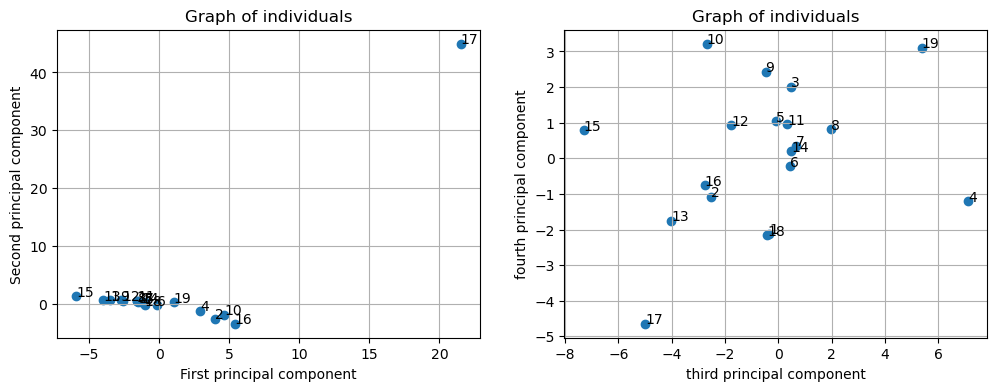

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
#plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes
for i, label in enumerate(labels):
    plt.annotate(label, (X_pca[i, 0], X_pca[i, 1]))
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("Graph of individuals")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 2], X_pca[:, 3])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes 
for i, label in enumerate(labels):
    plt.annotate(label, (X_pca[i, 2], X_pca[i, 3]))
plt.xlabel("third principal component")
plt.ylabel("fourth principal component")
plt.title("Graph of individuals")
plt.grid(True)

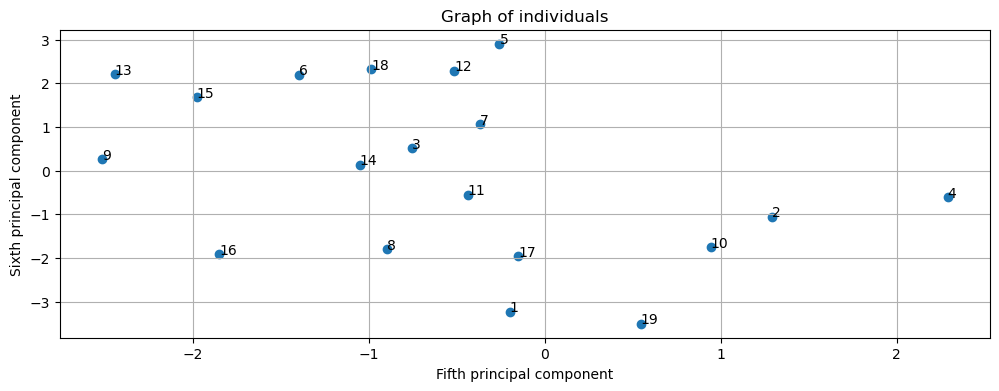

In [33]:
plt.figure(figsize=(12, 4))
plt.scatter(X_pca[:, 4], X_pca[:, 5])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes 
for i, label in enumerate(labels):
    plt.annotate(label, (X_pca[i, 4], X_pca[i, 5]))
plt.xlabel("Fifth principal component")
plt.ylabel("Sixth principal component")
plt.title("Graph of individuals")
plt.grid(True)

Considérons l'individu numéro 17. Il a un coefficient élevé sur les deux premiers axes factoriels, ce qui signifie qu'il fait un grand nombre d'activités par thématique d'apprentissage et à de bons scores aux différentes session d'évaluation. De plus il a un coefficient négatif relativement faible sur le reste des axes factoriels, ce qui signifie qu'il a des scores peu dispersé autour de la moyenne, il a de bonne performance académique et est plus ou moins régulier aux sessions d'apprentissage. En bref, c'est un bon élève.

Par contre, l'individu numéro 15 a un coefficient négatif sur le premier axe factoriel, proche de 0 sur le deuxième axe factoriel et négatif sur le troisième axe factoriel ce qui signifie qu'il ne fait relativement peu d'activités par thématique d'apprentissage et n'a pas de bonnes performances académique. De plus, il a un coefficient négatif sur le cinquième axe factoriel et proche de 0 sur le quatrième et sixième axe factoriel, ce qui traduit le fait qu'il est moin régulier aux examens et ses sessions d'apprentissage sont moins concentrées.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
2- Analyse Factorielle des Composantes Mixtes (FAMD) </u>
</p>
<br/>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
df= pd.read_parquet("data_Edu.parquet")
df_sample=df.sample(n=1000, random_state=42)
df_sample.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 119737 to 37920
Columns: 372 entries, unique_learner_id to pct_no_objective_weeks
dtypes: float64(71), int64(301)
memory usage: 2.8 MB


In [9]:
import os
import sys
import io

#sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8')


#definir l'emplacement de l'environnement r et des librairies utilisés
os.environ['R_HOME'] = r"C:\Program Files\R\R-4.4.2"  # Exemple : '/home/user/anaconda3/envs/mon_env/lib/R'
os.environ['R_LIBS_USER'] = r"C:\Users\damso\AppData\Local\R\win-library\4.4"
# Optionnel : Ajouter le chemin des DLLs de R pour éviter des erreurs de chargement
#os.environ['PATH'] += os.pathsep + r"C:\Program Files\R\R-4.4.2\bin\x64"

# Importer rpy2 et activer la conversion pandas2ri
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

#ro.r('library(factoextra)')
#ro.r('library(FactoMineR)')

# Charger les données dans R

base_AE = df_sample.reset_index(drop=True)

ro.globalenv['data'] = pandas2ri.py2rpy(base_AE)

# Récupérer les colonnes de type 'category'
category_columns = base_AE.select_dtypes(include=['category']).columns

# Convertir les noms des colonnes en liste pour les passer à R
ro.globalenv['category_columns'] = category_columns.tolist()


ro.r('''
    # Vérifier si les bibliothèques sont installées et les charger
    #if (!require("ggplot2")) install.packages("ggplot2")
    #if (!require("FactoMineR")) install.packages("FactoMineR")
    #if (!require("factoextra")) install.packages("factoextra")
     
    # Récupérer les noms des colonnes de type 'category' de Python
    category_columns <- as.character(category_columns)

    # Appliquer la conversion en factor sur ces colonnes
    data[category_columns] <- lapply(data[category_columns], as.factor)
    # Afficher les niveaux de chaque variable factor
    # Filtrer uniquement les variables de type factor
    #library(RColorBrewer)
    #library(ggplot2)
    library(FactoMineR)
    library(factoextra)
    # Exemple pour toutes les variables qualitatives
    result <- FAMD(data, ncp = 10, graph = FALSE)

    res <-summary(result)
    result_df <- as.data.frame(result$ind$coord) # Récupérer les coordonnées des individus
    result_var_df <- as.data.frame(result$var$coord) # Récupérer les coordonnées des individus
''')
# #Récupérer les résultats en Python
result_df = ro.r('result_df')
result_var_df = ro.r('result_var_df')
res = ro.r('res')
print(res)

result_df = pandas2ri.rpy2py(result_df)
result_var_df = pandas2ri.rpy2py(result_var_df)
result_var_df.info()
#print("Résultats de la FAMD :\n", result_df)

C:\Users\damso\AppData\Roaming\Python\Python312\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "unique_learner_id". Fall back to string conversion. The error is: integer -5875158997658804378 does not fit 'int'
  warnings.warn('Error while trying to convert '



Call:
FAMD(base = data, ncp = 10, graph = FALSE) 


Eigenvalues
                      Dim.1  Dim.2  Dim.3  Dim.4  Dim.5  Dim.6  Dim.7  Dim.8
Variance             90.295 11.598  8.886  8.203  5.524  5.081  4.990  4.497
% of var.             7.088  0.910  0.698  0.644  0.434  0.399  0.392  0.353
Cumulative % of var.  7.088  7.998  8.695  9.339  9.773 10.172 10.563 10.916
                      Dim.9 Dim.10
Variance              4.264  4.161
% of var.             0.335  0.327
Cumulative % of var. 11.251 11.578

Individuals (the 10 first)
                                            Dist     Dim.1     ctr    cos2  
0                                      |  40.694 | -12.141   0.163   0.089 |
1                                      |  36.188 |  -3.602   0.014   0.010 |
2                                      |  32.539 |   5.118   0.029   0.025 |
3                                      |  34.746 |   4.484   0.022   0.017 |
4                                      |  33.264 |   4.799   0.026   0.021

 10 variables ont été conservés et contiennent environ % de variance 

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
3- Auto Encoder </u>
</p>
<br/>

Nous commencons d'abord par exclure les identifiants ainsi que la variable de type datetime de la base q qui ne présentent aucun intérêt pour notre auto encoder

Pour des raisons liées à la puissance de calcul, nous nous servirons de la moité des observations pour notre Auto-Encoder. 

In [ ]:
base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(30000)

Les résultats obtenus avec un Auto-Encoder dépendent de la valeur de la dimension de l'espace latent choisi c'est à dire le nombre de variables de sorties. Dans un premier temps, nous réaliserons donc l'Auto-Encoder pour plusieurs valeurs de l'hyperparamètre (k allant de 1 à 20) et au vu des résultats déciderons d'une valeur optimale du paramètre 

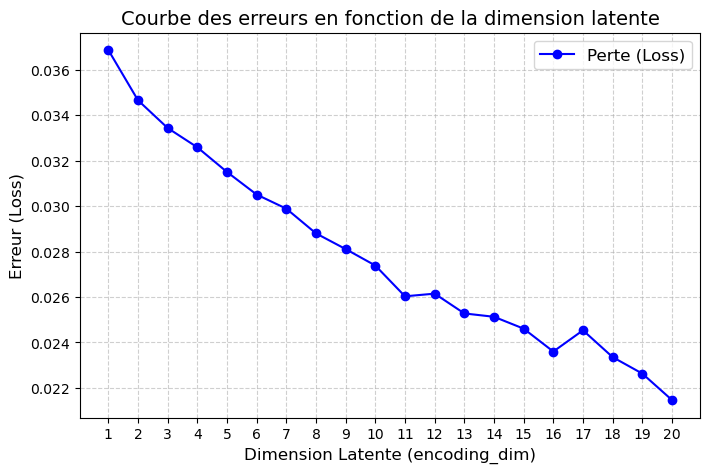

In [ ]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
input_dim = x_train.shape[1]

# === 3. Entraînement des autoencodeurs pour différentes dimensions latentes ===
results = []

for encoding_dim in range(1, 21):  # Tester des dimensions latentes de 1 à 20
    # Initialisation déterministe des poids
    initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

    # Construction de l'autoencodeur
    input_img = Input(shape=(input_dim,))
    # Encodeur
    Hidden1 = Dense(256, activation='relu', kernel_initializer=initializer)(input_img)
    Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
    Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
    encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden3)

    # Décodeur
    Hidden_output1 = Dense(64, activation='relu', kernel_initializer=initializer)(encoded)
    Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
    Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
    decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output3)#Plus touche


    # Créer le modèle
    autoencoder = Model(input_img, decoded)

    # Compiler le modèle
    autoencoder.compile(optimizer='adam', loss='mse')

    # Entraîner le modèle
    history = autoencoder.fit(
        x_train, x_train,
        epochs=50,
        batch_size=256,
        shuffle=True,
        validation_data=(x_test, x_test),
        verbose=0
    )

    # Récupérer la perte de validation à la dernière époque
    final_loss = history.history['val_loss'][-1]

    # Ajouter la dimension et la perte au tableau des résultats
    results.append({'encoding_dim': encoding_dim, 'loss': final_loss})

# === 4. Visualisation des résultats ===
df_results = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
plt.plot(df_results['encoding_dim'], df_results['loss'], marker='o', linestyle='-', color='b', label='Perte (Loss)')
plt.xlabel('Dimension Latente (encoding_dim)', fontsize=12)
plt.ylabel('Erreur (Loss)', fontsize=12)
plt.title('Courbe des erreurs en fonction de la dimension latente', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_results['encoding_dim'])
plt.legend(fontsize=12)
plt.show()


Le graphique précédent représente la courbe des erreurs en fonctions des valeurs de l'hyperparamètre k allant de 1 à 20. Elle présente globalement une tendence linéaire décroissante. Nous choississons de retenir pour notre autoencoder la valeur de l'hyperparamètre k=11 qui nous donne environ 0.0260 pour l'erreur de reconstruction ce qui est relativement faible. Le choix de k=11 pour l’autoencoder repose sur un compromis optimal entre compression et qualité de reconstruction. Ce seuil permet de capturer l’essentiel de l’information tout en limitant la complexité du modèle, réduisant ainsi le risque d’overfitting. En conservant un faible nombre de variables latentes, le modèle reste efficace et interprétable tout en garantissant une bonne généralisation des données. 

Epoch 1/50
83/83 [==============================] - 4s 28ms/step - loss: 0.0635 - val_loss: 0.0394
Epoch 2/50
83/83 [==============================] - 2s 20ms/step - loss: 0.0399 - val_loss: 0.0381
Epoch 3/50
83/83 [==============================] - 1s 18ms/step - loss: 0.0382 - val_loss: 0.0360
Epoch 4/50
83/83 [==============================] - 1s 17ms/step - loss: 0.0365 - val_loss: 0.0350
Epoch 5/50
83/83 [==============================] - 1s 17ms/step - loss: 0.0354 - val_loss: 0.0342
Epoch 6/50
83/83 [==============================] - 2s 20ms/step - loss: 0.0344 - val_loss: 0.0334
Epoch 7/50
83/83 [==============================] - 1s 17ms/step - loss: 0.0337 - val_loss: 0.0326
Epoch 8/50
83/83 [==============================] - 2s 19ms/step - loss: 0.0330 - val_loss: 0.0322
Epoch 9/50
83/83 [==============================] - 2s 19ms/step - loss: 0.0326 - val_loss: 0.0317
Epoch 10/50
83/83 [==============================] - 2s 19ms/step - loss: 0.0322 - val_loss: 0.0314
Epoch 11/

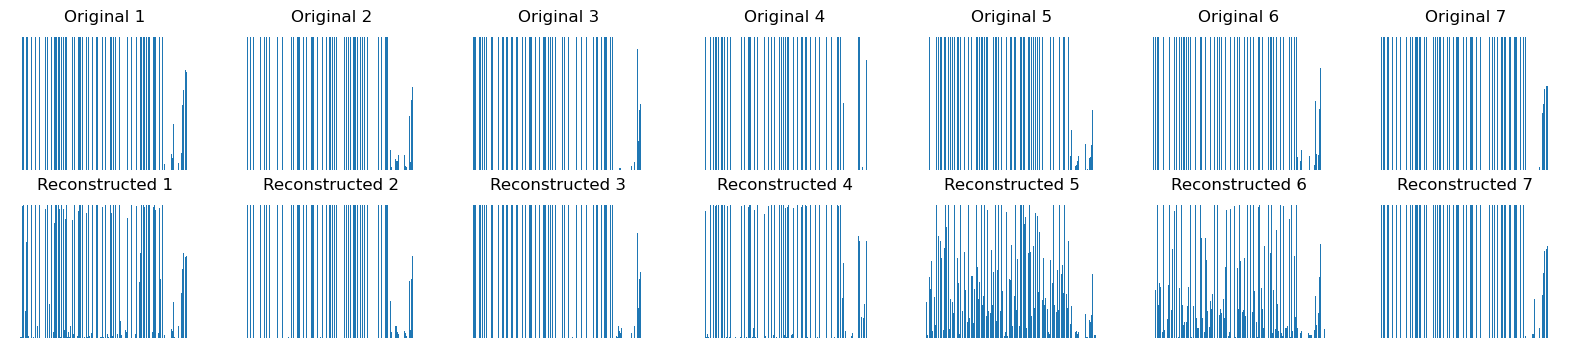

Erreur moyenne de reconstruction : 0.0260


In [ ]:
# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 11

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

# Encodeur
Hidden1 = Dense(256, activation='relu', kernel_initializer=initializer)(input_img)
Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden3)

# Décodeur
Hidden_output1 = Dense(64, activation='relu', kernel_initializer=initializer)(encoded)
Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output3)#Plus touche

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")


Le graphIque précédent fait une comparaison entre les 7 premières données originales et leurs versions reconstruites (pour une dimension k=10 de l'espace latent). Et la ressemblence obervée est très forte. Cela témoigne du fait que la valeur k=10 de l'hyperparamètre suffit à capturer efficacement la structure initiale de nos données. 

Nous essaierons maintenant de quantifier la part d'information conservé avec l'autoencoder dans le but d'évaluer sa performance. Pour celà, deux approches seront utilisées : 
* *La variance espliquée*

L'approche de la **variance totale par colonne** consiste à mesurer la dispersion des valeurs de chaque variable (ou colonne) dans un jeu de données et à calculer la variance pour chaque variable individuellement. Ensuite, on additionne ces variances pour obtenir la **variance totale** des données originales et reconstruites. Cette méthode permet de quantifier la quantité d'information conservée dans les données reconstruites en comparant la variance totale des données originales avec celle des reconstructions. Toutefois, cette approche repose sur l'hypothèse que les variables sont **indépendantes**. Elle ne prend pas en compte les relations de **corrélation** ou de **dépendance** entre les variables, ce qui peut être une limitation lorsque les variables sont fortement liées. En dépit de cela, elle reste une méthode simple et efficace pour estimer globalement l'information préservée après la reconstruction des données.

* *L'information mutuelle* 

L’information mutuelle est une mesure issue de la théorie de l’information qui quantifie la dépendance entre deux variables aléatoires. Elle indique la quantité d’information que l’on peut obtenir sur une variable en connaissant l’autre. Dans le cadre d’un autoencoder, elle permet d’évaluer combien d’information sur les données originales $X$ est préservée après reconstruction $𝑋_{hat}$.  

L’entropie, quant à elle, mesure l’incertitude ou la dispersion d’une variable aléatoire. Plus une distribution est uniforme, plus son entropie est élevée. Ici, l'entropie totale des variables d'origine $H(X)$ est utilisée pour normaliser l'information mutuelle 
$I(X,X_{hat})$, ce qui permet d’obtenir un taux d’information mutuelle conservée. Cette approche est plus interprétable que l’erreur quadratique moyenne (MSE), car elle capture la structure et la dépendance des données plutôt que de simples écarts numériques.

Nous commencons par l'approche se basant sur la variance expliquée

In [ ]:
import numpy as np

# Supposons que X_original et X_reconstructed sont tes données originales et reconstruites
#X_original = ...  # Tes données originales
X_reconstructed = autoencoder.predict(x_test) #...  # Tes données reconstruites

# Calculer la variance totale des données originales
total_variance_original = np.var(x_test, axis=0).sum()

# Calculer la variance totale des données reconstruites
total_variance_reconstructed = np.var(X_reconstructed, axis=0).sum()

# Calculer la part d'information conservée
info_conserved = (total_variance_reconstructed / total_variance_original) * 100

print(f"Part d'information conservée : {info_conserved:.2f}%")


282/282 [==============================] - 1s 5ms/step
Part d'information conservée : 61.14%


En se basant sur l'hypothèse d'indépendance entre les variables (ce qui n'est aps très évident), nous retrouvons comme résultat que notre autoencoder explique environ 61.14% de la variance de nos données originales, ce qui n'est pas négligeable et est plutôt rassurant. Mais le faible qu'elle se base sur une hypothèse peu réaliste la rend peu fiable

In [ ]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import entropy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# === 3. Taux d'information conservée avec l'information mutuelle ===

def compute_mutual_information(X, X_hat):
    mi_scores = []
    for i in range(X.shape[1]):  # Calcul de l'info mutuelle pour chaque variable
        mi = mutual_info_regression(X_hat[:, i].reshape(-1, 1), X[:, i])
        mi_scores.append(mi[0])  # mutual_info_regression renvoie une liste
    
    total_mi = np.sum(mi_scores)  # Somme sur toutes les variables
    return total_mi

def normalized_mutual_information(X, X_hat):
    H_X = np.sum([entropy(np.histogram(X[:, i], bins=20)[0] + 1e-10) for i in range(X.shape[1])])  # Entropie totale
    I_X_Xhat = compute_mutual_information(X, X_hat)  # Info mutuelle
    return I_X_Xhat / H_X  # Ratio d'info conservée

# Calcul du taux d'information mutuelle conservée
mi = compute_mutual_information(x_test, decoded_imgs)
nmi = normalized_mutual_information(x_test, decoded_imgs)
print(f"Information mutuelle totale : {mi:.4f}")
print(f"Part d'information conservée (normalisée) : {nmi:.2%}")


Information mutuelle totale : 119.9409
Part d'information conservée (normalisée) : 46.96%


Les résultats de l'approche par l'information mutuelle montrent que l'autoencoder conserve environ **47% de l'information** des données originales. Bien que ce chiffre indique une certaine perte d'information, il est globalement satisfaisant, car il montre que l'autoencoder réussit à préserver une proportion significative de l'information tout en réduisant la dimensionnalité des données. Cela suggère que l'autoencoder est assez performant dans la reconstruction des données tout en conservant l'essentiel des relations entre les variables.

L'approche par l'information mutuelle 

In [ ]:
autoencoder.save("autoencoder_model.h5")

Nous allons maintenant passer à l'interprétation des nos 10 variables latentes. Mais pour le faire il nous faut savoir quelles variables d'origines ont plus d'influence sur chacun des variables latentes. Pour capturer cette information, nous utiliserons la méthode GradiantExplainer de la bibliothèque shap qui nous donnera une approximation de l'effet d'une pertubation élémentaire de chacune des variables d'origine suer chacune des variables latentes. Ce effet sera utiliser pour déterminer quelles variables de départ influencent le plus quelle variable latente 

In [ ]:
import shap

# === 2. SHAP pour l'analyse des variables d'origine ===
# Adaptation du modèle pour SHAP ===
# Le modèle doit inclure les couches d'entrée jusqu'à l'encodage
#explainer = shap.DeepExplainer(encoder, x_train)  # Sous-échantillon de référence
explainer = shap.GradientExplainer(encoder, x_train)
# === 2. Récupérer les valeurs SHAP pour les données de test ===
shap_values = explainer.shap_values(x_test)  # Analyser un sous-échantillon de test

d:\Anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [ ]:
# # Vérification de la structure des valeurs SHAP
# print(f"Shape of shap_values: {len(shap_values)} dimensions latentes.")
# print(f"Shape of shap_values for first latent variable: {shap_values[0].shape}")
# print(f"Shape of x_test: {x_test.shape}")
# print(np.shape(shap_values))

In [ ]:
import pandas as pd

# Pour chaque dimension latente
for i in range(11):  # 10 dimensions latentes
    shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
    # Créer un DataFrame des valeurs SHAP pour les variables d'origine
    shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
    # Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
    mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    print(f"Les variables les plus influentes pour la {i+1}-ème dimension latente:")
    print(mean_shap_values.head(10))  # Afficher les 5 variables les plus influentes pour la dimension latente i+1


Les variables les plus influentes pour la 1-ème dimension latente:
is_first_exam_success_1                              0.608795
choice_00_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.300330
score_pct__first_location_of_minimum                 0.298047
choice_01_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.269674
choice_03_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.252407
percentage_serie_exam                                0.248449
has_passed_theory_exam_1                             0.242680
pct_no_objective_weeks                               0.237916
is_correct_bc4d741f-f4c0-4820-87c7-bf94a9245703_1    0.236765
choice_02_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.231201
dtype: float64
Les variables les plus influentes pour la 2-ème dimension latente:
pct_no_objective_weeks                              0.496991
is_first_exam_success_1                             0.373956
pct_study_objective_not_reached                     0.323991
score_pct__last_location_of_minimum             

La sortie précédente donne pour chacune des variables de la dimension latente les variables d'origine les plus influentes. Mais cette sortie serait plus intéressante sous forme de graphique.

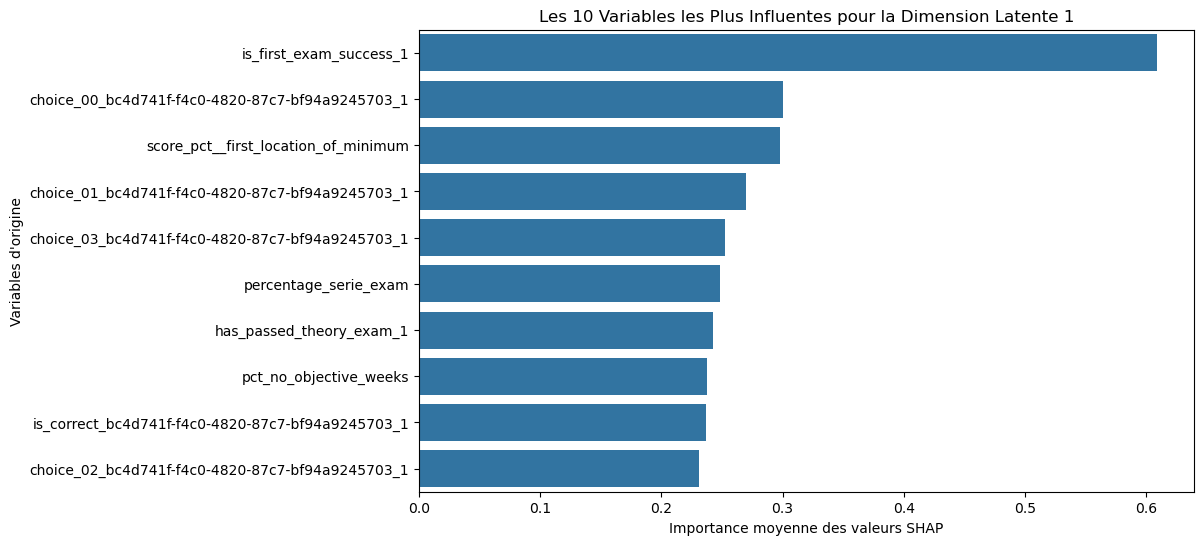

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=0 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette première dimension latente semble capturer une combinaison de facteurs liés à la réussite du permis de conduire, en particulier la réussite aux examens théoriques et pratiques. La variable la plus influente, *is_first_exam_success_1*, indique que cette dimension est fortement associée au fait de réussir dès la première tentative. Les choix de réponses aux questions du test (*choice_XX_...*) ainsi que les performances spécifiques (*score_pct__first_location_of_minimum*) suggèrent que cette dimension encode un mélange de compétences théoriques et de préparation. Enfin, la présence de *percentage_serie_exam* et *pct_no_objective_weeks* montre que cette dimension pourrait aussi refléter le niveau de pratique et d'entraînement avant l'examen.

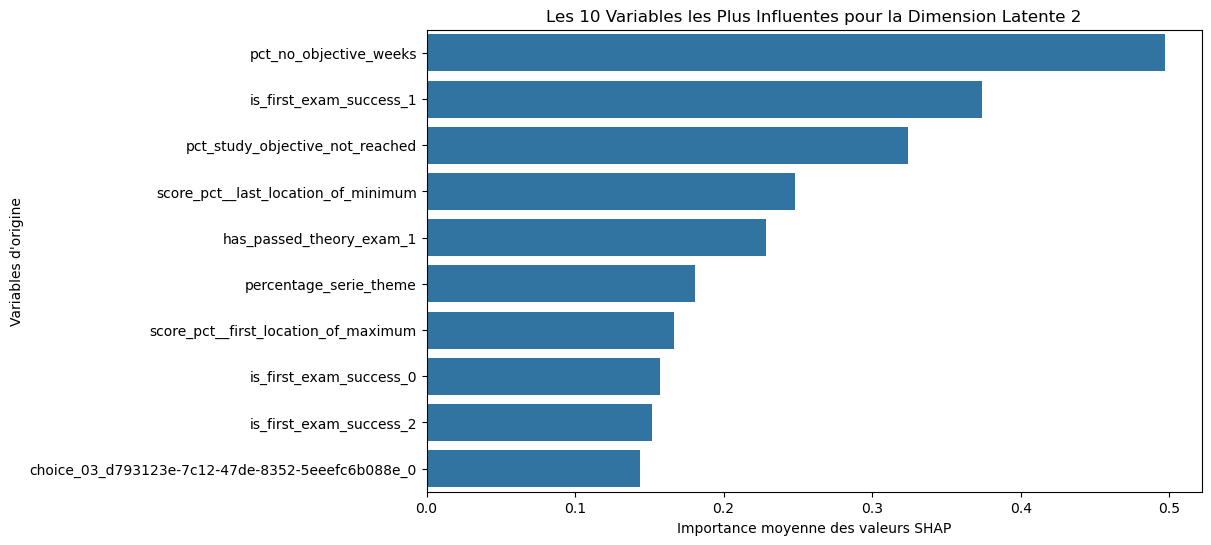

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=1 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette deuxième dimension latente semble être liée à la régularité et à l’atteinte des objectifs d’apprentissage dans la préparation au permis de conduire. La variable la plus influente, *pct_no_objective_weeks*, suggère que cette dimension capte le degré de planification et de suivi des objectifs d’étude. La forte influence de *pct_study_objective_not_reached* renforce cette idée, indiquant que cette dimension pourrait différencier les candidats qui suivent rigoureusement leur préparation de ceux qui sont plus irréguliers. La présence de *is_first_exam_success_* et *has_passed_theory_exam_* montre également que la réussite aux examens y joue un rôle, probablement en lien avec le niveau de préparation. Enfin, les scores aux tests (*score_pct__last_location_of_minimum*, *score_pct__first_location_of_maximum*) pourraient refléter des tendances dans la performance des candidats, suggérant une dimension qui mesure la progression et l’efficacité de l’apprentissage.

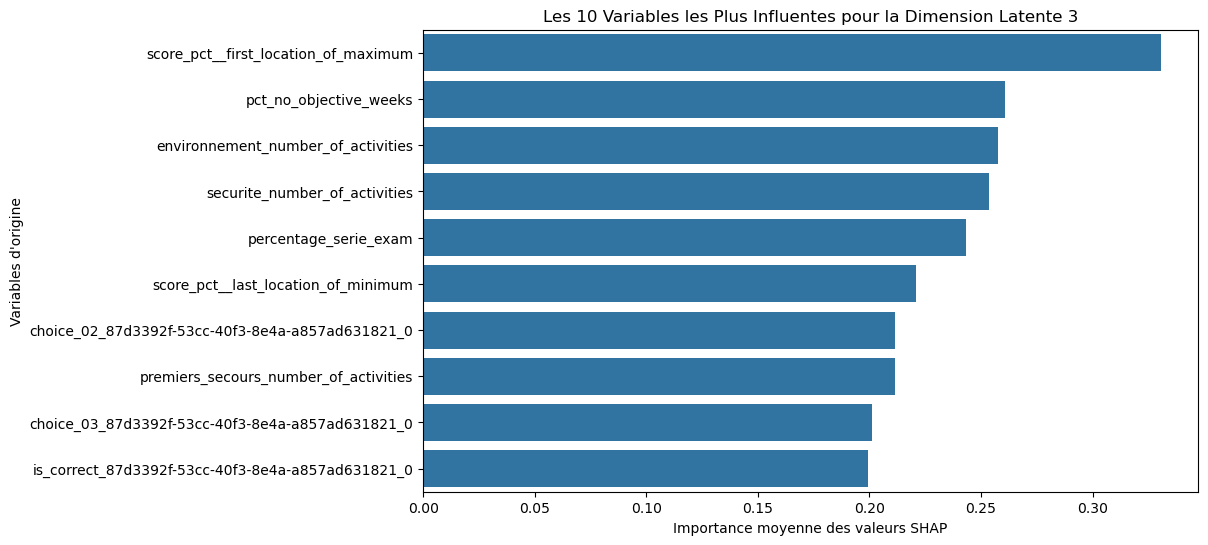

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=2 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette troisième dimension latente semble capturer l’engagement des candidats dans des activités liées à la formation au permis de conduire, ainsi que leur progression dans les tests. La forte influence de *score_pct__first_location_of_maximum* et *score_pct__last_location_of_minimum* suggère qu’elle reflète des aspects de la performance aux examens, notamment les moments où les scores maximaux et minimaux sont atteints. La présence de *pct_no_objective_weeks* indique également un lien avec la régularité de l’entraînement.  

Les variables *environnement_number_of_activities*, *securite_number_of_activities* et *premiers_secours_number_of_activities* montrent que cette dimension est aussi influencée par le nombre d’activités suivies dans différents domaines de la formation. Cela pourrait indiquer que cette dimension latente mesure l'implication globale dans la préparation, en incluant à la fois la théorie et des aspects pratiques comme la sécurité et les premiers secours. Enfin, les variables liées aux choix de réponses (*choice_XX_...* et *is_correct_...*) pourraient refléter la manière dont les candidats répondent à certains types de questions, suggérant une corrélation avec des stratégies d’apprentissage spécifiques.

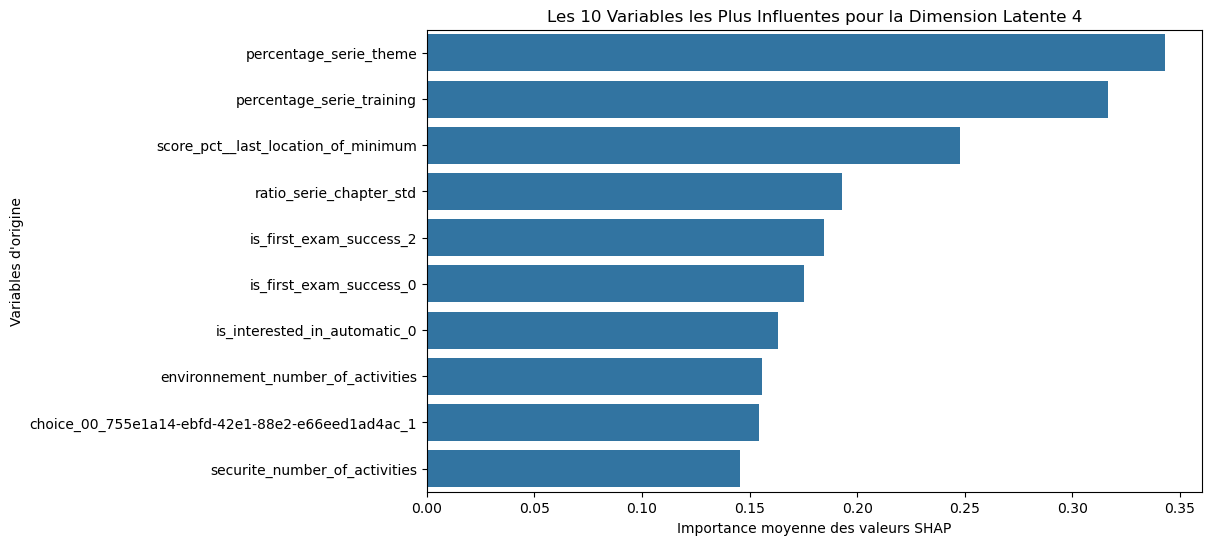

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=3 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette quatrième dimension latente semble refléter la manière dont les candidats structurent leur préparation au permis de conduire, notamment en termes de diversité des entraînements et de choix des thématiques étudiées. La forte influence de *percentage_serie_theme* et *percentage_serie_training* suggère qu’elle est liée à l’équilibre entre les différents types d’exercices et leur répartition dans le temps. La variabilité dans la répartition des chapitres (*ratio_serie_chapter_std*) renforce cette idée, indiquant que cette dimension pourrait différencier les candidats ayant une approche méthodique de ceux ayant une préparation plus désorganisée.  

L’influence des variables *is_first_exam_success_0* et *is_first_exam_success_2* laisse penser que cette dimension distingue ceux qui ont échoué au test de ceux qui ne l’ont pas encore passé ou n’ont pas renseigné leur statut. Cela pourrait refléter une opposition entre candidats expérimentés, mais ayant rencontré des difficultés, et ceux encore en phase de préparation. La variable *is_interested_in_automatic_0* pourrait également jouer un rôle, suggérant que les préférences en matière de transmission influencent le type d’entraînement suivi. Enfin, la présence des activités spécifiques (*environnement_number_of_activities*, *securite_number_of_activities*) montre que cette dimension intègre aussi l’implication dans des aspects pratiques de la formation.

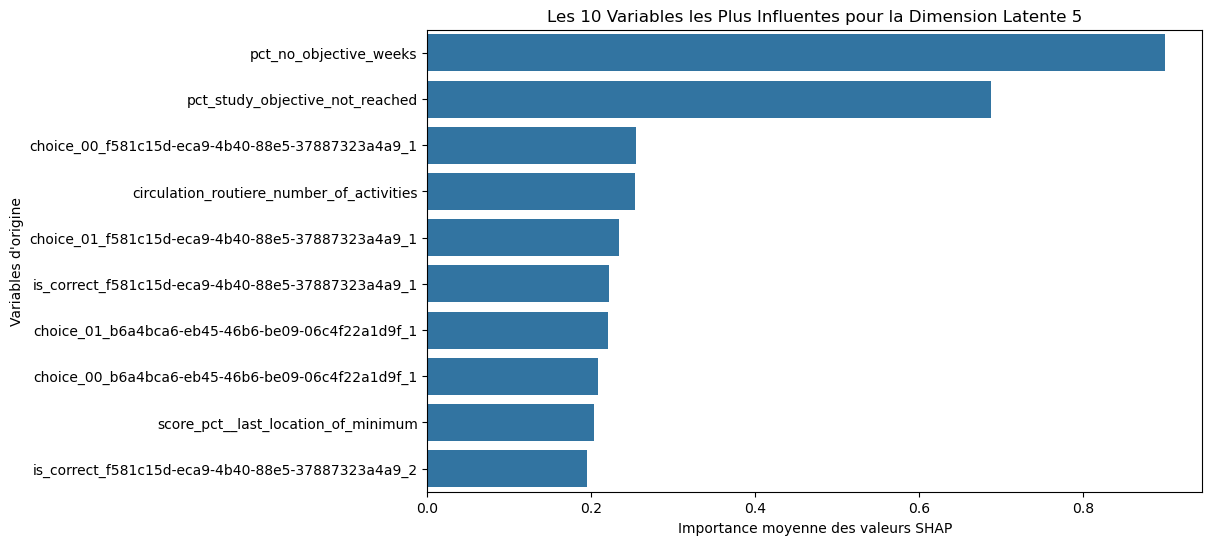

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=4 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette cinquième dimension latente semble être fortement liée à la régularité et à la gestion des objectifs d'étude dans la préparation au permis de conduire. Les variables *pct_no_objective_weeks* et *pct_study_objective_not_reached* montrent que cette dimension capte bien la discipline et le suivi des objectifs d'apprentissage, particulièrement chez ceux qui n'ont pas atteint leurs objectifs d'étude. Cela pourrait suggérer que cette dimension représente une forme de frustration ou de manque de progression dans la préparation.  

Les choix de réponses (*choice_00_...*, *choice_01_...*) et les réponses correctes (*is_correct_...*) montrent que cette dimension prend aussi en compte la manière dont les candidats interagissent avec les questions du test, indiquant une relation entre les difficultés dans les tests et l'atteinte des objectifs. La variable *circulation_routiere_number_of_activities* suggère également que cette dimension pourrait être liée à la pratique en circulation, impliquant un lien avec les aspects pratiques du permis. Enfin, *score_pct__last_location_of_minimum* pourrait indiquer que cette dimension distingue les candidats qui rencontrent des difficultés dans certaines sections du test, mais continuent de persévérer.

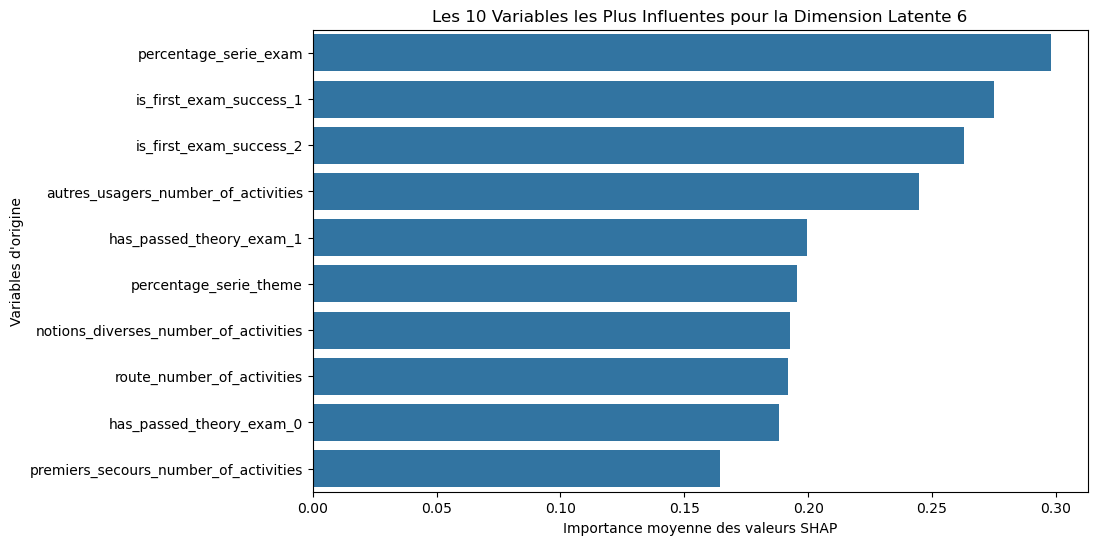

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=5 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette sixième dimension latente semble capturer des aspects liés à la progression générale des candidats dans leur préparation au permis de conduire, notamment leur réussite aux examens et leur participation à diverses activités pratiques. La variable *percentage_serie_exam* indique que cette dimension est en partie influencée par la quantité de séries d’examens suivies, ce qui suggère une relation avec l’engagement dans les tests.  

Les variables *is_first_exam_success_1* et *is_first_exam_success_2* montrent que la réussite au premier examen, ou l’absence de renseignement sur celui-ci, joue un rôle important dans cette dimension, avec une distinction claire entre ceux qui réussissent dès la première tentative et ceux qui ne l’ont pas encore passé. L’influence de *has_passed_theory_exam_1* et *has_passed_theory_exam_0* montre également une corrélation avec la réussite ou l’échec aux examens théoriques. 

Les activités pratiques, telles que *autres_usagers_number_of_activities*, *route_number_of_activities*, et *premiers_secours_number_of_activities*, révèlent que cette dimension intègre également la diversité des expériences pratiques suivies, notamment celles liées à la circulation et à la sécurité routière. Cela suggère que la dimension latente pourrait refléter un candidat ayant une préparation plus équilibrée, combinant théorie et pratique, et ayant un taux de réussite plus élevé en conséquence.

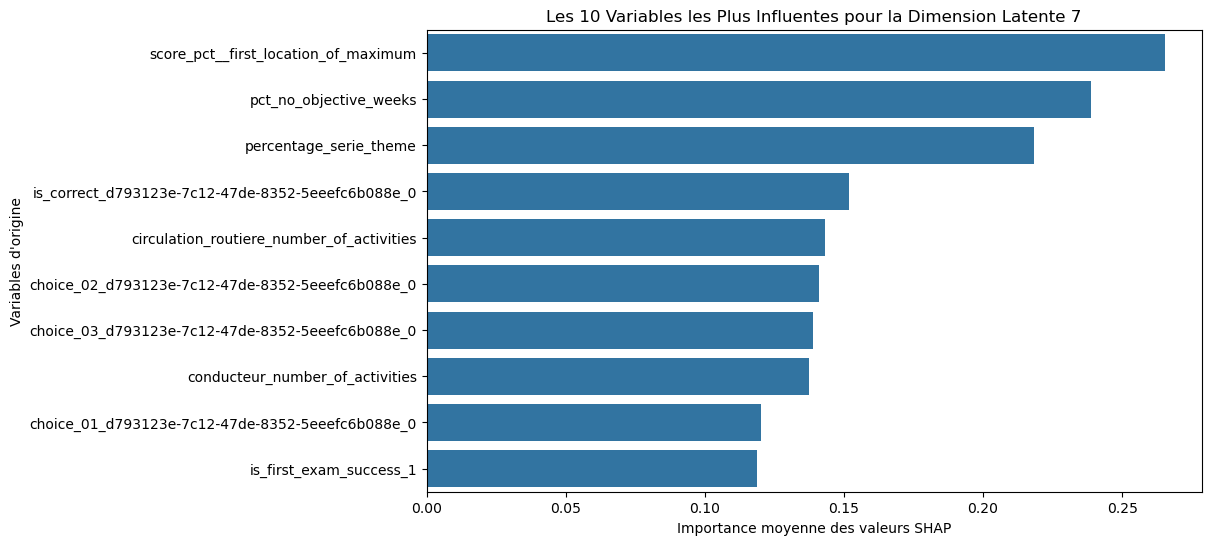

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=6 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette septième dimension latente semble être centrée sur la performance et l'engagement dans la préparation, en particulier en relation avec les tests pratiques et théoriques. La variable *score_pct__first_location_of_maximum* suggère que cette dimension capte des éléments de la performance des candidats, notamment les moments où ils obtiennent leurs meilleurs scores dans le test. Cela peut indiquer une dimension où la maîtrise de certaines compétences, comme les tests de connaissances spécifiques, joue un rôle clé.

Les variables *pct_no_objective_weeks* et *percentage_serie_theme* montrent un lien avec l'organisation et la structure de la préparation, suggérant que les candidats ayant un plan d'étude plus rigoureux pourraient se retrouver dans cette dimension. La présence des variables liées aux activités pratiques (*circulation_routiere_number_of_activities* et *conducteur_number_of_activities*) indique que l'engagement dans des pratiques concrètes est également un facteur influent dans cette dimension, peut-être en lien avec l'apprentissage de la conduite elle-même.

Les choix de réponses aux tests (*choice_XX_d793123e-7c12-47de-8352-5eeefc6b088e_0*) et la variable *is_correct_d793123e-7c12-47de-8352-5eeefc6b088e_0* montrent que cette dimension est également liée à la capacité des candidats à répondre correctement aux questions des examens. Enfin, *is_first_exam_success_1* indique que cette dimension reflète probablement un groupe de candidats qui ont réussi le premier examen, suggérant que la dimension latente capte ceux qui sont plus susceptibles de réussir dès la première tentative.

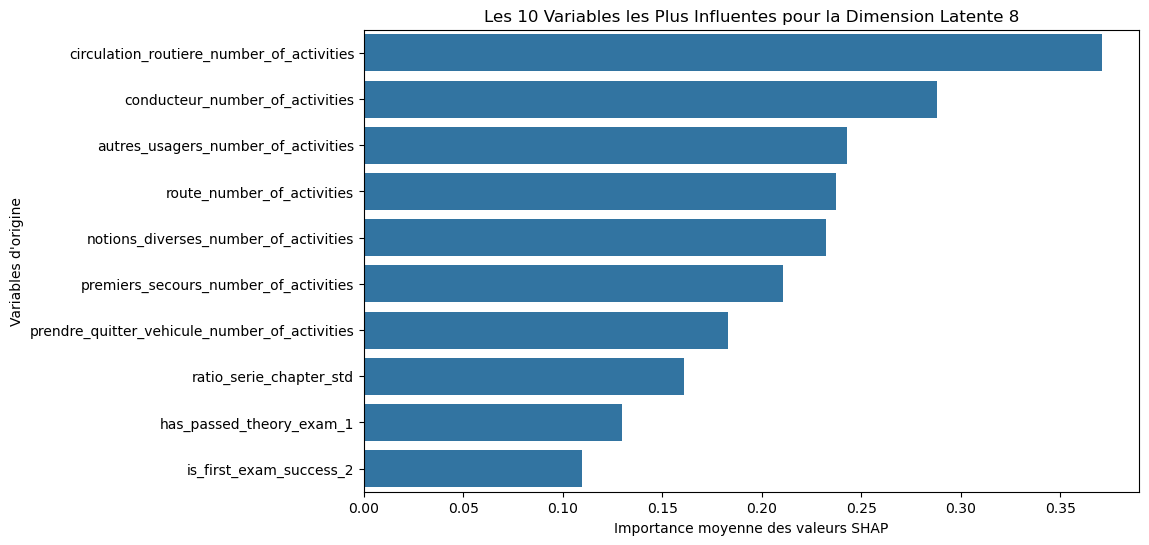

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=7 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette huitième dimension latente semble fortement axée sur l’implication pratique des candidats dans la préparation au permis de conduire. Les variables *circulation_routiere_number_of_activities*, *conducteur_number_of_activities*, et *route_number_of_activities* indiquent que la pratique de la conduite, l’apprentissage de la circulation routière, et l’implication dans des activités liées à la route sont des éléments clés dans cette dimension. Cela suggère que cette dimension représente les candidats qui s’engagent activement dans des expériences de conduite et des formations pratiques.

L’influence de *notions_diverses_number_of_activities* et *premiers_secours_number_of_activities* indique aussi que des connaissances plus larges et des formations en sécurité, telles que les premiers secours, jouent un rôle dans cette dimension, suggérant une préparation plus complète. *prendre_quitter_vehicule_number_of_activities* pourrait être lié aux pratiques concernant la gestion du véhicule, telles que l'entrée et la sortie du véhicule dans des contextes spécifiques. 

Le *ratio_serie_chapter_std* montre que cette dimension inclut aussi des candidats ayant un parcours d’étude plus varié, avec des différences dans la répartition des chapitres d'étude. Les variables *has_passed_theory_exam_1* et *is_first_exam_success_2* ajoutent des éléments de performance théorique et de statut de réussite, indiquant que cette dimension peut aussi inclure des candidats ayant passé leur examen théorique, mais avec un éventuel retard ou un échec à la première tentative. En somme, cette dimension semble capturer l’engagement pratique et la diversité des expériences dans la préparation au permis.

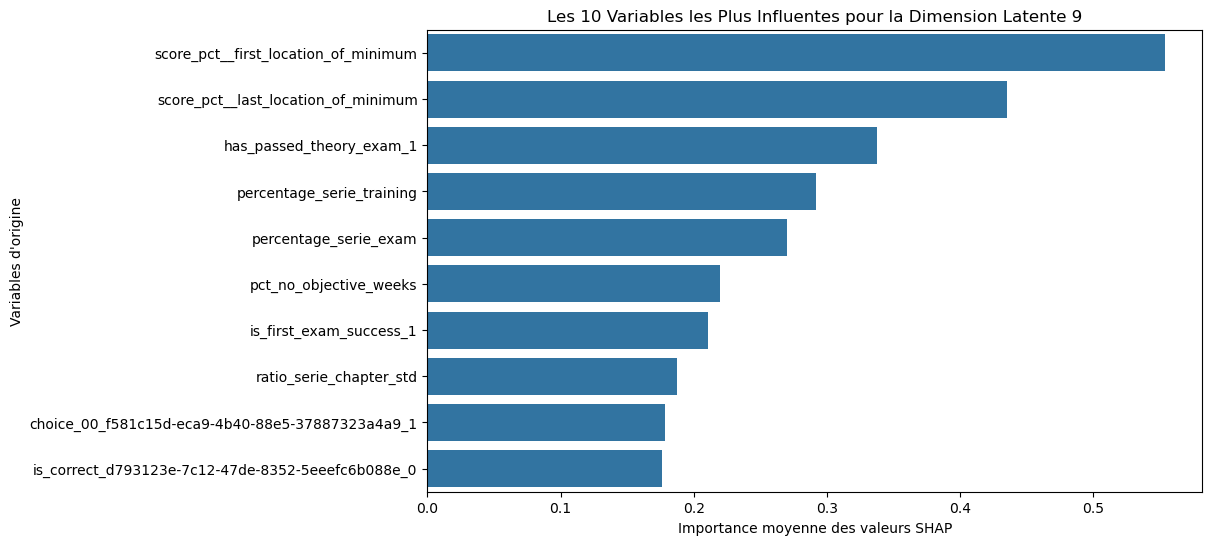

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=8 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


Cette neuvième dimension latente semble être centrée sur les aspects liés aux résultats des tests, à la performance dans les séries d'examens et à la préparation théorique. Les variables *score_pct__first_location_of_minimum* et *score_pct__last_location_of_minimum* suggèrent que cette dimension capte des aspects de la performance des candidats en termes de scores les plus bas dans les tests, ce qui pourrait indiquer des difficultés dans certaines parties de l'examen ou une tendance à l'échec dans certaines sections spécifiques.

Les variables *has_passed_theory_exam_1* et *is_first_exam_success_1* confirment que cette dimension est liée à ceux qui ont réussi l'examen théorique, avec une distinction pour ceux qui ont réussi dès la première tentative. L'influence de *percentage_serie_training* et *percentage_serie_exam* indique que l'engagement dans la préparation (en termes de formation et de séries d'examens) a un impact important sur cette dimension, suggérant que les candidats ayant suivi une préparation plus approfondie sont mieux représentés dans cette dimension.

*PCT_no_objective_weeks* indique que l'absence d'objectifs précis dans la préparation pourrait aussi avoir un impact, bien que moins fort. La variable *ratio_serie_chapter_std* montre que cette dimension reflète aussi la variabilité dans la manière dont les candidats répartissent leur temps et leurs efforts d'étude, avec des candidats ayant des parcours d'étude plus standardisés. Enfin, les variables *choice_00_f581c15d-eca9-4b40-88e5-37887323a4a9_1* et *is_correct_d793123e-7c12-47de-8352-5eeefc6b088e_0* montrent que cette dimension capture également l'influence des choix de réponses lors des tests et des bonnes réponses fournies, ce qui renforce l'idée que cette dimension est liée à la performance testée et à la préparation théorique.

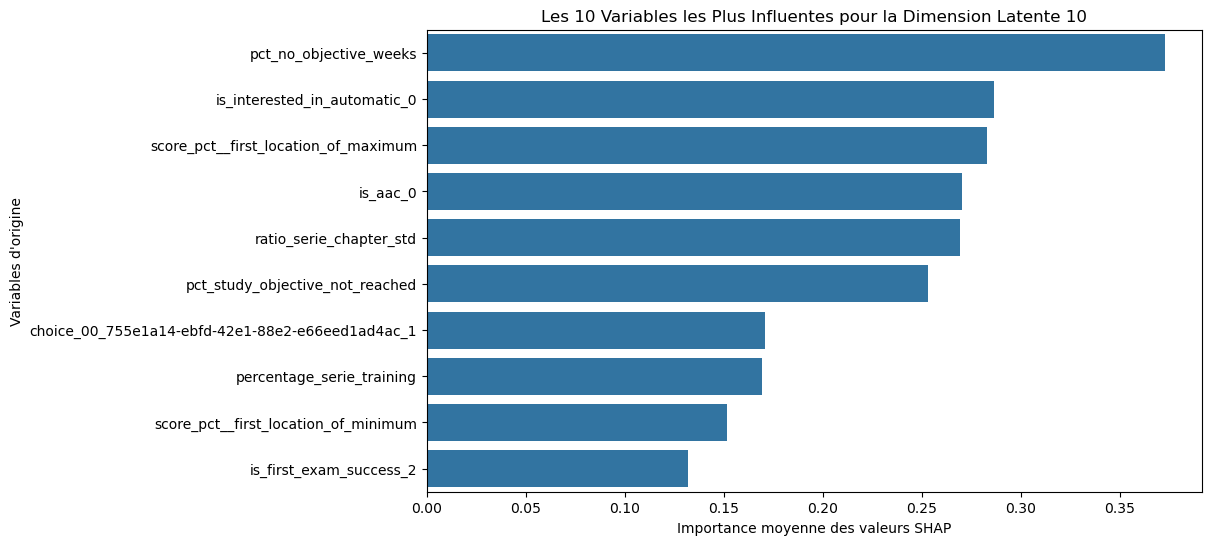

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=9 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


La dixième dimension latente semble refléter une combinaison de facteurs liés à la motivation personnelle, à la préparation à l'examen, et aux difficultés rencontrées dans le parcours d’apprentissage. 

*PCT_no_objective_weeks* indique que cette dimension est fortement influencée par les semaines passées sans objectifs clairs, suggérant que l'absence d'objectifs précis dans la préparation peut caractériser cette dimension. 

L'influence de *is_interested_in_automatic_0* et *is_aac_0* indique un lien avec les préférences personnelles et le statut par rapport à certaines formations ou tests, telles que la préférence pour un permis automatique ou un statut d'examen spécifique. Cela pourrait refléter un groupe de candidats ayant des choix ou des difficultés particuliers en matière de type de permis ou de préparation.

Les variables *score_pct__first_location_of_maximum* et *score_pct__first_location_of_minimum* montrent une attention particulière aux extrêmes de performance (les scores les plus élevés et les plus bas), suggérant que cette dimension est influencée par une variété de performances, incluant des pics de réussite ou des moments de difficulté. 

La variable *ratio_serie_chapter_std* met en évidence la diversité des parcours d’études, en particulier dans les chapitres de formation, et pourrait signifier que cette dimension représente des candidats ayant une approche d'étude moins homogène. En outre, *pct_study_objective_not_reached* reflète l'impact des objectifs d'étude non atteints, ce qui souligne une difficulté dans l'atteinte des objectifs fixés. Enfin, la faible influence de *is_first_exam_success_2* confirme que cette dimension peut inclure des candidats qui n'ont pas encore passé ou réussi le test.

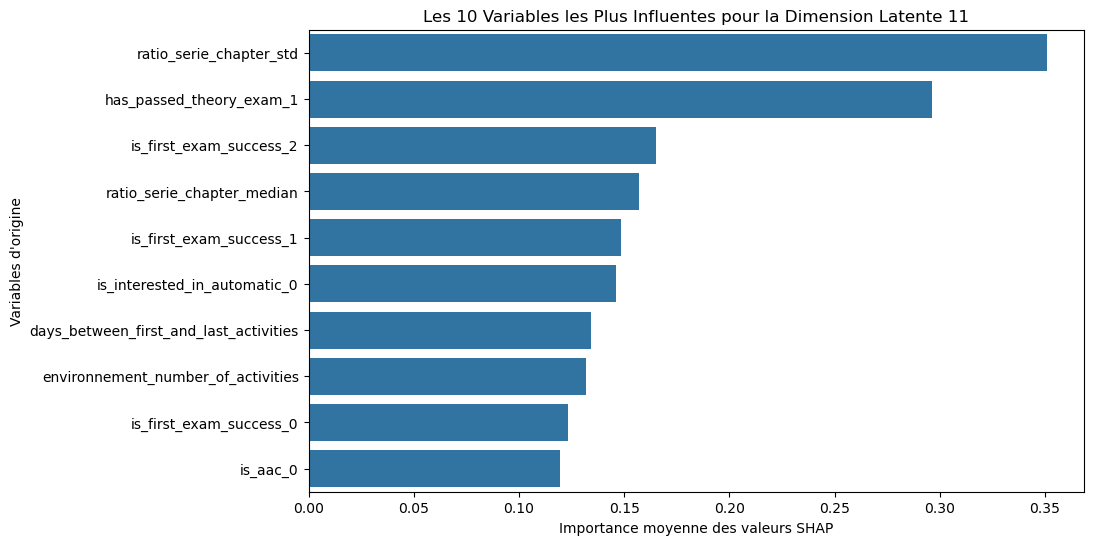

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pour chaque dimension latente
i=10 # dimensions latentes
shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
# Créer un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
# Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    
# Affichage des 5 variables les plus influentes sous forme de barplot horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_shap_values.head(10).values, y=mean_shap_values.head(10).index, orient='h')  # Orienté horizontalement
plt.title(f"Les 10 Variables les Plus Influentes pour la Dimension Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.show()


La onzième dimension latente semble être centrée sur les habitudes d'étude, le passage du test théorique et les résultats associés, tout en mettant en évidence l'impact de la préparation et des choix personnels.

La variable *ratio_serie_chapter_std* suggère que cette dimension est fortement influencée par la variabilité dans la manière dont les candidats répartissent leur temps et leurs efforts d’étude entre les différents chapitres de la série. Cela pourrait indiquer que les candidats de cette dimension ont des profils d’étude diversifiés, avec des variations dans leur approche d’apprentissage.

*has_passed_theory_exam_1* montre que cette dimension inclut une proportion importante de candidats ayant réussi l'examen théorique, et la variable *is_first_exam_success_1* confirme qu'une partie des individus ont réussi l'examen dès leur première tentative. Cependant, *is_first_exam_success_2* indique aussi la présence de ceux qui n'ont pas encore passé ou qui n’ont pas renseigné les résultats du test, ce qui montre une certaine hétérogénéité dans les candidats représentés par cette dimension.

La variable *ratio_serie_chapter_median* suggère également une influence de la répartition médiane du temps d’étude, ce qui peut signaler que les candidats de cette dimension ont un parcours d’étude relativement équilibré.

*is_interested_in_automatic_0* et *is_aac_0* montrent que cette dimension peut également inclure des préférences spécifiques en matière de type de permis ou de statut d’examen. De plus, *days_between_first_and_last_activities* met en évidence une dimension temporelle dans le processus d'étude, représentant des candidats qui peuvent avoir des périodes plus longues entre leurs premières et dernières activités, indiquant peut-être une approche plus étendue ou désorganisée.

Enfin, *environnement_number_of_activities* et *is_first_exam_success_0* montrent une influence de l'environnement d’étude et de ceux qui n’ont pas réussi à passer leur premier examen.